# CSCK507 Mid Module - Toxic Comment Classification Challenge

## Table of Contents
[Section 1. Introduction](#introduction)
- [Import Dependencies](#import-dependencies)
- [Loading Kaggle dataset into DataFrame](#import-dependencies)
- [Initialise SpaCy Model ](#import-dependencies)

[Section 2. Data Exploration & Analysis](#data-exploration-&-analysis)
- [2.1 Data Preparation and Preprocessing](#data-exploration-&-analysis)
    - [2.1.1 Dataset Alignment](#data-preprocessing)
    - [2.1.2 Text Preprocessing](#data-preprocessing)
    - [2.1.3 Tokenisation and Lemmatisation](#data-preprocessing)
    - [2.1.4 Combining Tokenised Features and Labels for Training and Test Dataset](#data-preprocessing)
- [2.2 Data Analysis Requirements](#data-exploration-&-analysis)
    - [2.2.1 Number of Sentences & Tokens Per Class](#data-preprocessing)
    - [2.2.2 Data Imbalance](#data-imbalance)
    - [2.2.3 Understanding the Most Common Words](#data-preprocessing)
    - [2.2.4 Data Analysis Summary](#data-imbalance)
    
[Section 3. Machine Learning Model Development](#data-exploration-&-analysis)
- [3.1 Feature Extraction Methods](#data-preprocessing)
    - [3.1.1 TF-IDF Implementation](#data-preprocessing)
    - [3.1.2 Word Embedding](#data-preprocessing)
- [3.2 Model Selection & Training](#data-exploration-&-analysis)
    - [3.2.1 Logistic Regression](#data-preprocessing)
    - [3.2.2 Multinomial Naive Bayes](#data-preprocessing)
    - [3.2.3 Multi-Layer Perceptron](#data-preprocessing)


[Section 4. Evaluation of Selected Models](#data-exploration-&-analysis)
- [4.1 Feature Extraction Methods](#data-preprocessing)



---
## Section 1. Introduction

Originating in 2018, this challenge revolves around classifying different levels of toxicity in online comments. The dataset from the inaugural competition is utilized to analyze and evaluate the performance of various machine learning algorithms in categorizing six types of toxicity. The primary goal is not only to find an optimal solution but to understand the process of evaluating machine learning algorithms' performance in a classification task. This individual assessment involves data analysis, algorithm selection, and the exploration of feature extraction methods to uncover insights into the nuances of toxic comment classification.

The Toxic Comment Classification Challenge and dataset can be obtained here: [Kaggle Challenge](https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data)

### Importing Dependencies

In [73]:
# General
import os
import pandas as pd 
import numpy as np

# For Data Preprocessing
import re  
import nltk
from nltk.corpus import stopwords

# For Feature Extraction  
import dill
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

# For Machine Learning
# from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.multiclass import OneVsRestClassifier
# from sklearn.model_selection import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn import metrics 
# import eli5

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For Warning Handling
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

### Load Kaggle dataset into DataFrame

In [2]:
df = pd.read_csv('dataset/train.csv')
df_test_labels = pd.read_csv('dataset/test_labels.csv')
df_test_comment = pd.read_csv('dataset/test.csv')

### Initialise SpaCy Model 

In [3]:
try:
    spacy.prefer_gpu()
    nlp = spacy.load('en_core_web_sm')
except (LookupError, OSError):
    print('Run: python -m spacy download en_core_web_sm')

try:
    nltk_stop = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    nltk_stop = stopwords.words('english')

---
## Section 2. Data Exploration & Analysis

In [30]:
df.sample(10).head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
144391,0c50408ed7ca7bdd,consensus around Wikipedia war way There propo...,0,0,0,0,0,0
141100,f3085f1a099b9653,appreciate article great participated What eve...,0,0,0,0,0,0
15448,28cdb851c42a86ea,Muslim values threat Valentine Day Linkjs,0,0,0,0,0,0
99640,151185f70eb0430a,Original work Week The Thank Barnstar Wikipedi...,0,0,0,0,0,0
144365,0be8ab27a0ba7dc9,nuclear spots least I picture revels two oozed...,0,0,0,0,0,0
9175,1870a7e6240ea8ef,Is Wrong bottom The n paste block Strauss Joha...,0,0,0,0,0,0
85124,e3c0b9077a97dec8,short deleted could unreferenced essay Or,0,0,0,0,0,0
99866,166cea1a33ca6d9a,Which References throwing need allegations pro...,0,0,0,0,0,0
103992,2c5f901524a9fe48,point moreover empirically Reliable referring ...,0,0,0,0,0,0
30566,5125ff19698165c6,said people Hitler kill think homosexuals Adol...,1,0,0,1,1,1


In [25]:
df.info()
print("The table dimensions are:",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB
The table dimensions are: (159571, 8)


In [32]:
print(df.loc[30566])

id                                                5125ff19698165c6
comment_text     said people Hitler kill think homosexuals Adol...
toxic                                                            1
severe_toxic                                                     0
obscene                                                          0
threat                                                           1
insult                                                           1
identity_hate                                                    1
Name: 30566, dtype: object


As shown above, hate comments exhibit a nuanced interplay of multiple labels. This complexity necessitates a multi-label classification approach for a more accurate understanding and identification of diverse toxic behaviors

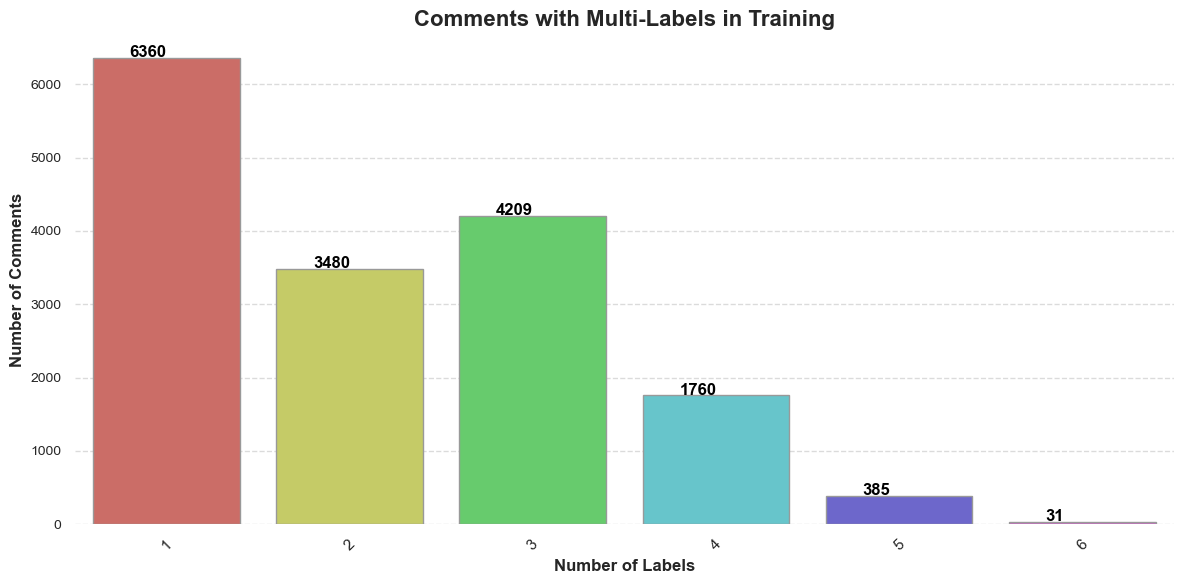

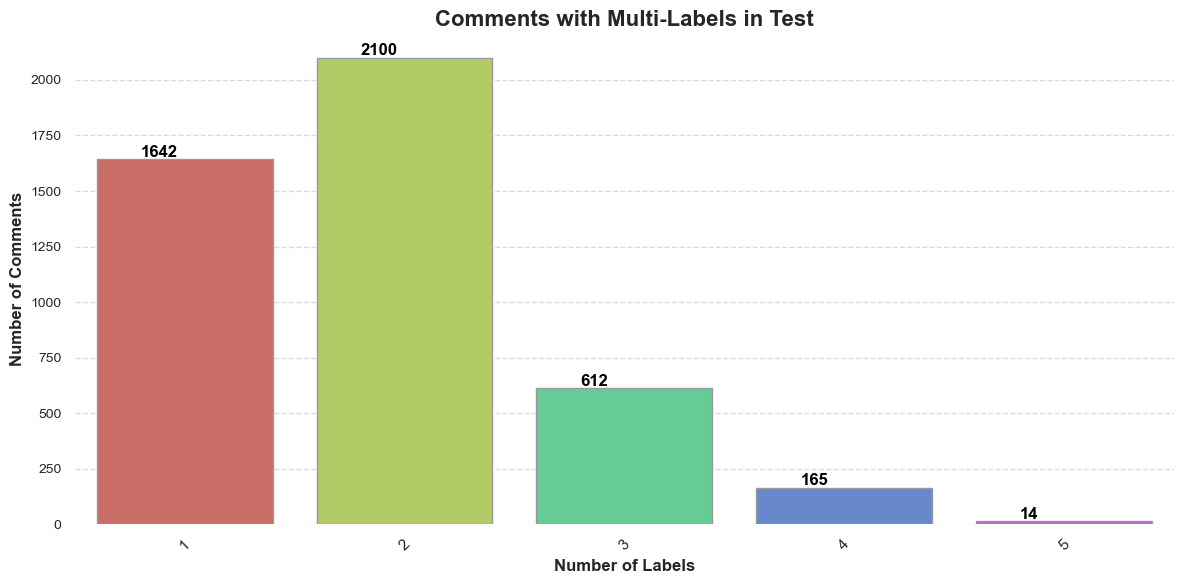

In [49]:
def plot_multilabel_count(df, title, offset=10):
    row_sums = df.iloc[:, 2:].sum(axis=1)
    label_counts = row_sums.value_counts().sort_index(ascending=True)[1:]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=label_counts.index, y=label_counts.values, palette="hls", edgecolor=".6")
    
    for i, v in enumerate(label_counts.values):
        plt.text(i - 0.2, v + offset, str(v), color='black', fontweight='bold')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('Number of Labels', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Comments', fontsize=12, fontweight='bold')
    plt.xticks(rotation=45)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

# Plot number of comments with multiple labels
plot_multilabel_count(df, 'Comments with Multi-Labels in Training')
plot_multilabel_count(df_test, 'Comments with Multi-Labels in Test')

### Dataset Alignment

In [52]:
try:
    class_labels = list(df.columns[2:])
    print("Class labels extracted.")

    # Remove rows with -1 from 'df_test' since they are not used for scoring
    print(f'df_test before removing -1: {df_test_labels.shape}')
    
    for class_label in class_labels:
        df_test_labels = df_test_labels[df_test_labels[class_label] != -1]
    print(f'df_test after removing -1: {df_test_labels.shape}')

    # Left join 'df_test' and 'df_test_comment' on the 'id' column
    df_test = pd.merge(df_test_labels, df_test_comment, on='id', how='left')

    # Create a new DataFrame called 'df_test' and match the column structure of 'df'
    df_test = df_test[['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
    print("New DataFrame 'df_test' created.")

except KeyError as ke:
    print(f"Error: {ke} not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Class labels extracted.
df_test before removing -1: (63978, 7)
df_test after removing -1: (63978, 7)
New DataFrame 'df_test' created.


### Data Preprocessing, Tokenisation, and Lemmatisation

The preprocessing step plays a critical role in cleansing and standardising textual data for manageability purposes. This stage typically consists of tasks, such as:

- Removing URLs, extra spaces, and non-English characters
- Trimming start and end white spaces
- Eliminating leading and trailing spaces and quotation marks
- Discarding single characters
- Eliminating punctuation without converting to lowercase

**Note:** An area worth noting in hate speech detection scenarios, preserving the original case is essential, as individuals expressing anger may resort to typing in all caps, and ignoring case distinctions would hinder the effectiveness of the model. As such, it is not performed below.

In [8]:
def preprocess_text(text, nltk_stop=None):
    try:
        if nltk_stop is None:
            nltk_stop = set(stopwords.words('english'))
    except LookupError:
        print("NLTK stopwords not available. Consider downloading with nltk.download('stopwords').")

    try:
        # Combine URL removal, extra space replacement, and Non-English characters removal
        text = re.sub(r"(http\S+|www\S+|https\S+)|[^\x00-\x7F]+", " ", text)
        # Remove start and end white spaces
        text = text.strip()
        # Remove leading and trailing spaces and quotation marks
        text = text.strip('"')
        # Remove single characters
        text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
        # Remove punctuations.
        text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
        # Stopword Removal using set operations
        text = ' '.join(set(text.split()) - nltk_stop)

        return text

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return None

### Tokenisation and Lemmatisation

In [46]:
def tokenize_lemma_text(documents):
    """
    Tokenize a list of documents and perform the following:
    1. Break text into individual words or subword tokens.
    2. Reduce words to their base or root form using lemmatization.
    3. Remove stop words and non-alphabetic characters.

    Utilises spaCy's nlp.pipe for efficient batch processing.

    :param documents: List of strings representing documents.
    :return: List of lists of strings, where each list corresponds to the lemmatized tokens of a document.
    """
    lemmatized_tokens_list = []
    
    # Process documents using spaCy's nlp.pipe with 'NER' and 'Parser' components disabled utilising 4 core parallel processing:
    for doc in nlp.pipe(documents, disable=["ner", "parser"], batch_size=5000, n_process=4):
        lemmatized_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in nlp.Defaults.stop_words]
        lemmatized_tokens_list.append(lemmatized_tokens)

    return lemmatized_tokens_list

In many tokenisation tasks, especially those emphasizing lemmatisation and stop word removal, the additional linguistic information provided by the 'NER' and 'Parser' components is often unnecessary. 

**Disabling** these components during the processing of documents using 'nlp.pipe' can substantially reduce computational load and significantly improve efficiency and speed. This is particularly crucial when dealing with extensive amounts of text data, presenting a trade-off between computational resources and the need for specific linguistic information tailored to the task.

**Note:** Another critical facet worth discussing is that while SpaCy conveniently handles all aspects performed in the 'preprocess_text' function regarding URL removal, whitespace trimming, stopword removal, etc. The linguistic analysis performed by SpaCy introduces some overhead, making it relatively slower for simple tasks compared to a more lightweight solution like RegEx.

In [47]:
# Preprocess the train dataset
df['comment_text'] = df['comment_text'].apply(preprocess_text)
print("Preprocessed training dataset:")

Preprocessed training dataset:


In [48]:
#Display random rows from the training set
random_rows_train = df.sample(n=10) 
display(random_rows_train)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
128448,aef629876ebb5d55,Whirlygirl article The name redirect without s...,0,0,0,0,0,0
13890,24a91b23a45ed755,saw said That personal known talk Don It ugly ...,0,0,0,0,0,0
31445,537d12773e451f31,continue If stop blocked Wikipedia editing van...,0,0,0,0,0,0
114342,639367ef585e8aed,Danish things Help resources need parts care c...,0,0,0,0,0,0
22564,3b98fdad6ce57543,The voted Heads creator seems Spring12 delete ...,0,0,0,0,0,0
42379,71111d709a1b767d,call Leave alone Sandove89,0,0,0,0,0,0
123307,93959f2ca3442eee,right reopening case think close,0,0,0,0,0,0
8445,167121ab857b5711,Warring Shang Talk much yes flurry made Han We...,0,0,0,0,0,0
27452,48abe18ba8a773a8,please brewing reversed Trent merge Talk Burto...,0,0,0,0,0,0
142453,f9f7081efc149861,anything take harassment com think clearly wis...,0,0,0,0,0,0


In [12]:
# Preprocess the test dataset
df_test['comment_text'] = df_test['comment_text'].apply(preprocess_text)

In [13]:
# Tokenizing the train and test datasets
tokenized_comment_train = tokenize_lemma_text(df['comment_text'].tolist())
tokenized_comment_test = tokenize_lemma_text(df_test['comment_text'].tolist())

In [14]:
# Get labels for train and test data
y_train = df[class_labels]
y_test = df_test[class_labels]

### Combining Tokenised Text Features & Labels for Training and Test Dataset

In [15]:
# For training data
df_train = pd.DataFrame({
    'comment_text': tokenized_comment_train,    # Tokenized comment text
    'toxic': y_train['toxic'],                        # Toxicity label
    'severe_toxic': y_train['severe_toxic'],          # Severe toxicity label
    'obscene': y_train['obscene'],                    # Obscenity label
    'threat': y_train['threat'],                      # Threatening language label
    'insult': y_train['insult'],                      # Insult label
    'identity_hate': y_train['identity_hate']         # Identity hate label
})

display(df_train.head())
print("The train dataset dimensions are:",df.shape)

# For test data
df_test = pd.DataFrame({
    'comment_text': tokenized_comment_test,     # Tokenized comment text for testing
    'toxic': y_test['toxic'],                   # Toxicity label for testing
    'severe_toxic': y_test['severe_toxic'],     # Severe toxicity label for testing
    'obscene': y_test['obscene'],               # Obscenity label for testing
    'threat': y_test['threat'],                 # Threatening language label for testing
    'insult': y_test['insult'],                 # Insult label for testing
    'identity_hate': y_test['identity_hate']    # Identity hate label for testing
})

display(df_test.head())
print("The test dataset dimensions are:",df_test.shape)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[retire, vote, York, edit, page, Hardcore, rev...",0,0,0,0,0,0
1,"[d, match, UTC, January, talk, thank, I, seemi...",0,0,0,0,0,0
2,"[hey, relevant, war, info, edit, page, guy, re...",0,0,0,0,0,0
3,"[statistic, later, exact, turn, review, let, g...",0,0,0,0,0,0
4,"[chance, hero, remember, sir, page]",0,0,0,0,0,0


The train dataset dimensions are: (159571, 8)


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,"[thank, highly, revert, discussion, think, und...",0,0,0,0,0,0
1,"[horrible, Dear, god, site]",0,0,0,0,0,0
2,"[people, bring, crap, category, Beckett, Amos,...",0,0,0,0,0,0
3,"[grant, Centers, Community, need, Stop, York, ...",0,0,0,0,0,0
4,"[reader, possibility, product, relevant, prove...",0,0,0,0,0,0


The test dataset dimensions are: (63978, 7)


### 2.1 Task 1 Requirements

**Number of Sentences and Tokens**
- Analyze the number of sentences and tokens per class
- Check if the dataset is unbalanced or not

**Most Common Words Analysis**
- Examine the most common words for each class.

### Counting Number of Sentences & Tokens Per Class

In [16]:
import pandas as pd

class_counts = {'class_label': [], 'num_sentences': [], 'num_tokens': []}

for class_label in class_labels:
    class_comments = df_train[df_train[class_label] == 1]['comment_text'].tolist()

    total_sentences = 0
    total_tokens = 0

    for comment in class_comments:
        # Join the list of comments into a single string
        comment_text = " ".join(comment)

        # Count the number of sentences in the comment
        sentences = comment_text.split('.')
        total_sentences += len(sentences)

        # Count the number of tokens in the comment
        tokens = comment_text.split()
        total_tokens += len(tokens)

    class_counts['class_label'].append(class_label)
    class_counts['num_sentences'].append(total_sentences)
    class_counts['num_tokens'].append(total_tokens)
    
class_counts_df = pd.DataFrame(class_counts)

print(class_counts_df)

     class_label  num_sentences  num_tokens
0          toxic          15294      244332
1   severe_toxic           1595       19346
2        obscene           8449      126553
3         threat            478        6886
4         insult           7877      115134
5  identity_hate           1405       21881


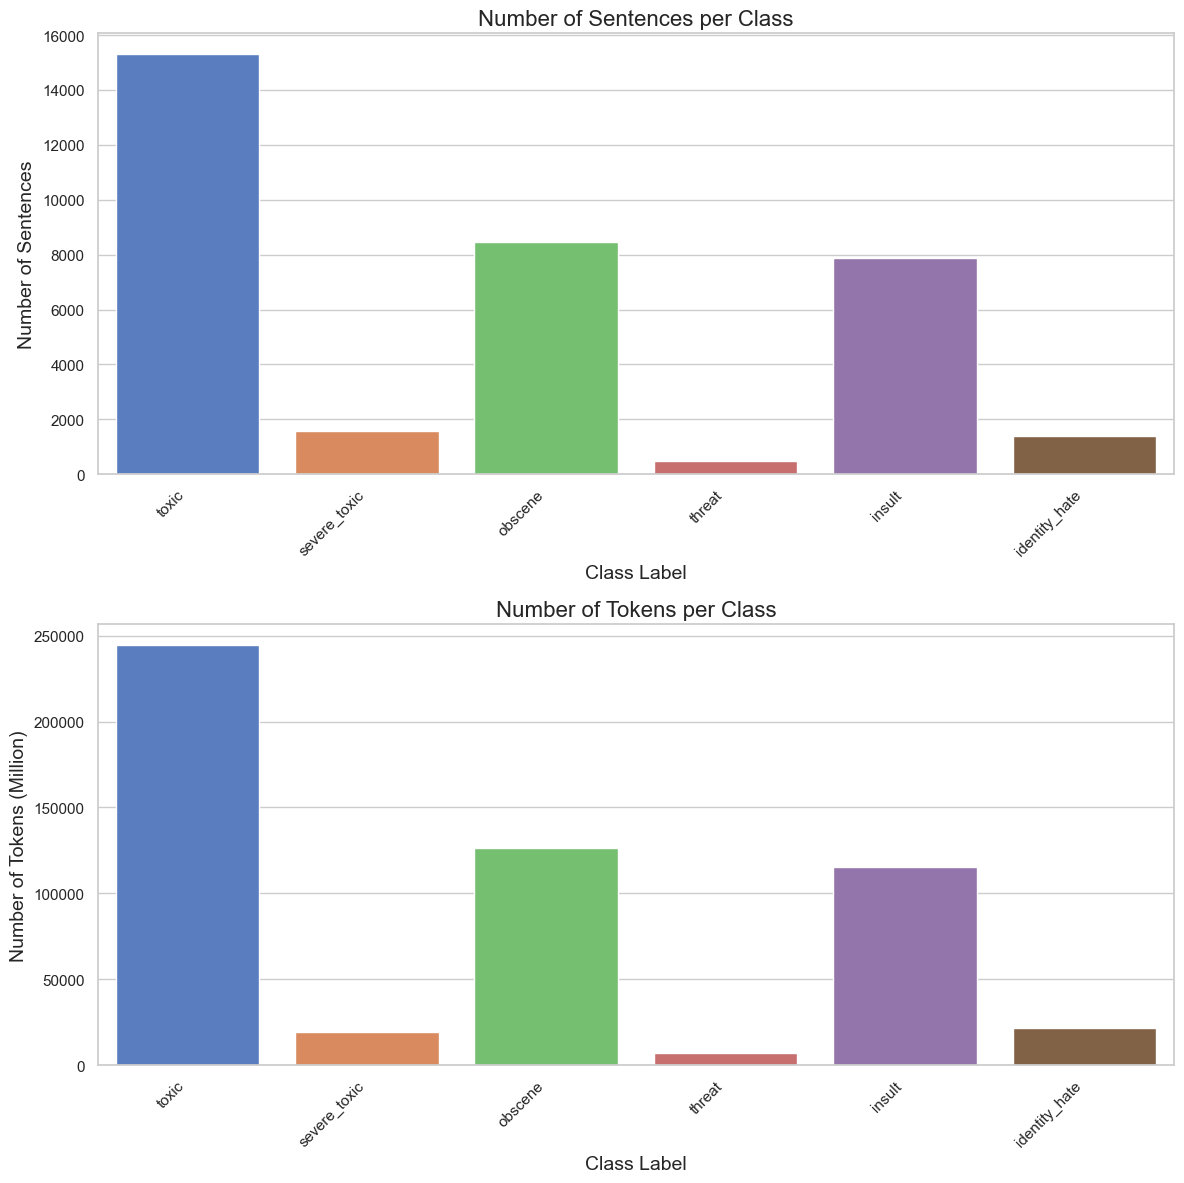

In [53]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot the number of sentences per class
sentences_plot = sns.barplot(
    ax=axes[0],
    x='class_label',
    y='num_sentences',
    data=class_counts_df,
    palette="muted"
)
sentences_plot.set_title('Number of Sentences per Class', fontsize=16)
sentences_plot.set_xlabel('Class Label', fontsize=14)
sentences_plot.set_ylabel('Number of Sentences', fontsize=14)
sentences_plot.set_xticklabels(sentences_plot.get_xticklabels(), rotation=45, ha='right') 

# Plot the number of tokens per class
tokens_plot = sns.barplot(
    ax=axes[1],
    x='class_label',
    y='num_tokens',
    data=class_counts_df,
    palette="muted"
)
tokens_plot.set_title('Number of Tokens per Class', fontsize=16)
tokens_plot.set_xlabel('Class Label', fontsize=14)
tokens_plot.set_ylabel('Number of Tokens (Million)', fontsize=14)
tokens_plot.set_xticklabels(tokens_plot.get_xticklabels(), rotation=45, ha='right')  

plt.tight_layout() 
plt.show()

warnings.filterwarnings(action='ignore')

### Understanding the Most Common Words in Training Data

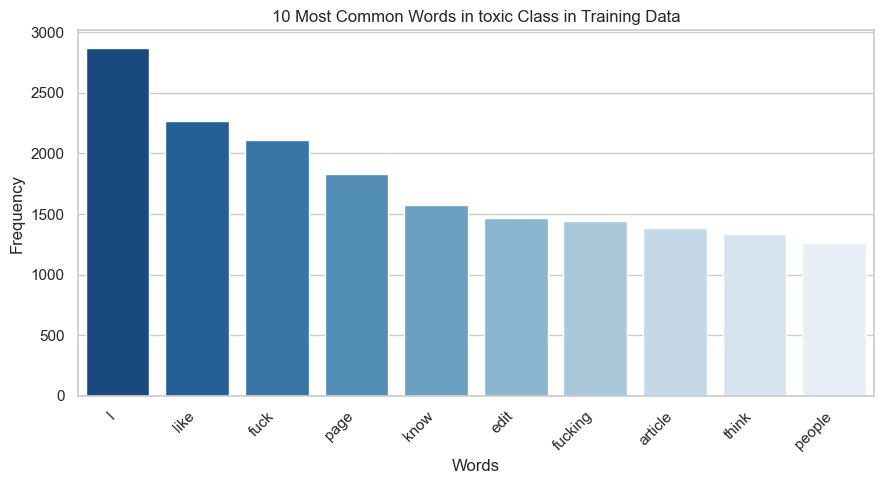

Most common words in toxic class: [('I', 2870), ('like', 2270), ('fuck', 2109), ('page', 1833), ('know', 1571), ('edit', 1471), ('fucking', 1444), ('article', 1385), ('think', 1335), ('people', 1264)]


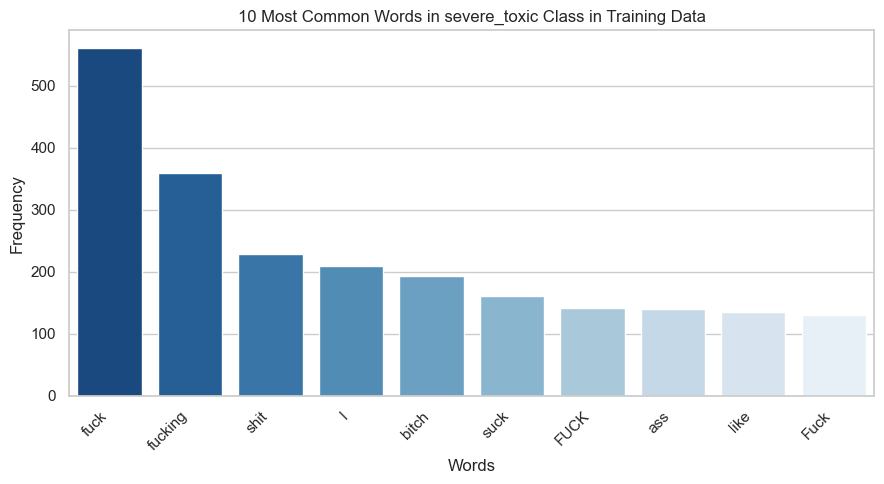

Most common words in severe_toxic class: [('fuck', 561), ('fucking', 360), ('shit', 228), ('I', 209), ('bitch', 194), ('suck', 161), ('FUCK', 141), ('ass', 140), ('like', 136), ('Fuck', 131)]


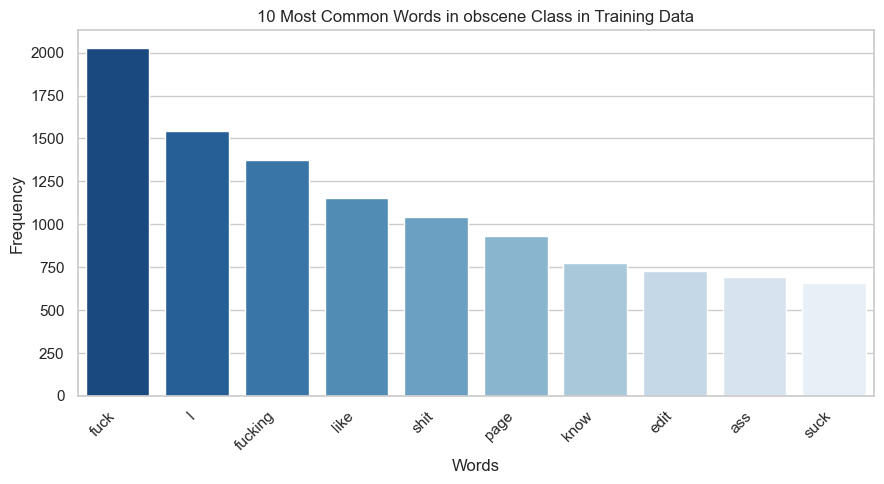

Most common words in obscene class: [('fuck', 2028), ('I', 1545), ('fucking', 1375), ('like', 1156), ('shit', 1040), ('page', 929), ('know', 774), ('edit', 729), ('ass', 694), ('suck', 657)]


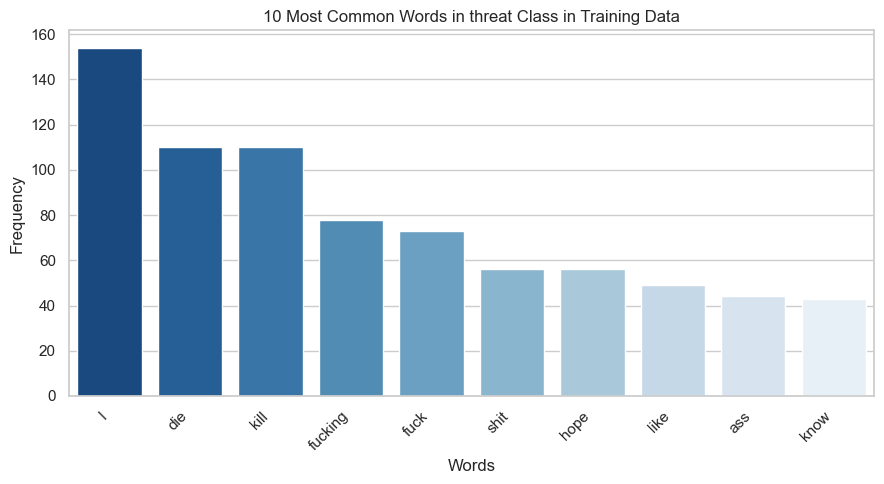

Most common words in threat class: [('I', 154), ('die', 110), ('kill', 110), ('fucking', 78), ('fuck', 73), ('shit', 56), ('hope', 56), ('like', 49), ('ass', 44), ('know', 43)]


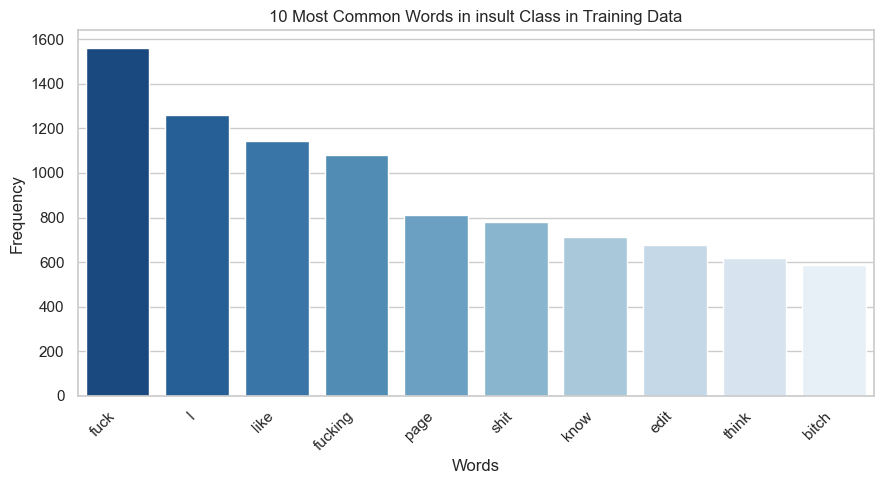

Most common words in insult class: [('fuck', 1561), ('I', 1262), ('like', 1142), ('fucking', 1080), ('page', 813), ('shit', 780), ('know', 711), ('edit', 675), ('think', 618), ('bitch', 589)]


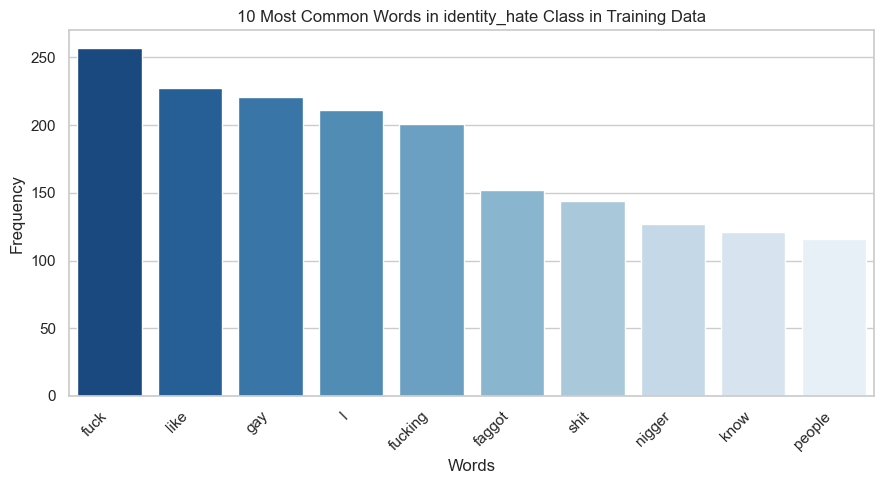

Most common words in identity_hate class: [('fuck', 257), ('like', 227), ('gay', 221), ('I', 211), ('fucking', 201), ('faggot', 152), ('shit', 144), ('nigger', 127), ('know', 121), ('people', 116)]


In [65]:
def plot_common_words(counts, title):
    labels = [word for word, _ in counts]
    freqs = [count for _, count in counts]

    # Use seaborn for a visually appealing vertical bar plot
    plt.figure(figsize=(9, 5))
    sns.barplot(x=labels, y=freqs, palette="Blues_r")  
    
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()  
    plt.show()

# Visualize the 10 most common words for each class distribution
for label in class_labels:
    words = []
    for comment in df_train[df_train[label] == 1]['comment_text']:
        words.extend(comment)
    
    most_common_words = Counter(words).most_common(10)
    
    # Plot and display the 10 most common words
    plot_common_words(most_common_words, f'10 Most Common Words in {label} Class in Training Data')
    
    # Print the most common words for the class
    print(f'Most common words in {label} class: {most_common_words}')

warnings.filterwarnings(action='ignore')

### Exploring Class Distribution and Imbalance 

In [66]:
class_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for column in class_columns:
    class_counts = df[column].value_counts()
    
    print(f"{column.capitalize()} Counts:")
    for index, count in class_counts.items():
        class_label = "Non-" + column if index == 0 else column
        print(f"{class_label}: {count}")
    
    print()

Toxic Counts:
Non-toxic: 144277
toxic: 15294

Severe_toxic Counts:
Non-severe_toxic: 157976
severe_toxic: 1595

Obscene Counts:
Non-obscene: 151122
obscene: 8449

Threat Counts:
Non-threat: 159093
threat: 478

Insult Counts:
Non-insult: 151694
insult: 7877

Identity_hate Counts:
Non-identity_hate: 158166
identity_hate: 1405



### Task 1 Summary

Based on the output of category_counts and category_counts_test above, we can see that the data is highly imbalanced. There are more non hatespeeches than the hatespeech in the dataset

While data augmentation techniques can be used to balance the data, we will use class weights to balance the data during training.

Class weights are calculated as the inverse of the class frequency in the training data, per sci-kit learn documentation:

Formula: n_samples / (n_classes * np.bincount(y))

Due to the highly imbalanced nature of this dataset, accuracy might not be a good metric for evaluation. Precision, Recall or AUC would be more suitable.

To be consistent with the evaluation metric of the competition, we will use ROC-AUC as the evaluation metric for our models.

---
## Section 3. Feature Extraction

### TF-IDF Implementation

TF-IDF weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF:** Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization:

**TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).**

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

**IDF(t) = log_e(Total number of documents / Number of documents with term t in it).**

In [72]:
# Function to save the TF-IDF vectorizer
def save_vectorizer(vectorizer, filename):
    with open(filename, 'wb') as f:
        dill.dump(vectorizer, f)

# Function to load the TF-IDF vectorizer if it exists, otherwise return None
def load_vectorizer(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return dill.load(f)
    else:
        return None

# Function to fit and transform using TF-IDF vectorizer
def fit_transform_tfidf(vectorizer, train_data, test_data):
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    return X_train_tfidf, X_test_tfidf

# Instantiate or load the TF-IDF vectorizer
tfidf_vectorizer_filename = 'tf-idf/tfidf_vectorizer.dill'
tfidf_vectorizer = load_vectorizer(tfidf_vectorizer_filename)

if tfidf_vectorizer is None:
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=75_000, tokenizer=lambda x: x, preprocessor=lambda x: x)
    save_vectorizer(tfidf_vectorizer, tfidf_vectorizer_filename)

# Fit and transform the training and test features
X_train_tfidf, X_test_tfidf = fit_transform_tfidf(tfidf_vectorizer, df_train['comment_text'], df_test['comment_text'])

# Extract class labels
y_train_tfidf = df_train[class_labels]
y_test_tfidf = df_test[class_labels]

Saving the TF-IDF vectorizer is a common practice in ML workflow, allowing for:

**Consistent Feature Representation:** By saving the TF-IDF vectorizer, you ensure consistency in the feature representation of your data. When deploying a machine learning model, you'll often want to use the same vectorizer that was used during training to transform the input data into the format expected by the model.

**Scalability:** If your model is trained on a large dataset and the TF-IDF vectorizer is computationally expensive to fit, saving it allows you to avoid re-computing the vectorizer when deploying the model. This can be particularly useful in production scenarios.
Reproducibility:

Saving the vectorizer ensures that you can reproduce the same feature transformations in the future. 

### Word Embedding



Word2Vec

In [ ]:
X_train_tfidf.shape, y_train.shape, X_test_tfidf.shape, y_test.shape

## Section 4. Machine Learning Model Development

In this secion we cover 3 ML Models:
- LR
- Multinomial NB
- MLP Classifier
- Support Vector Machine (SVM)

As this task is a multi-label classification problem, we will use a classifiers wrapped in a OneVsRestClassifier wrapper.

**Logistic Regression:**

Advantages:
Interpretability: Logistic Regression is a simple and interpretable model, making it easy to understand the impact of individual features on the prediction.
Efficiency: It performs well with a large number of features, making it suitable for NLP tasks where text data is often high-dimensional.

Applicability to NLP: Logistic Regression is a natural fit for binary classification tasks, such as hate speech detection, where the goal is to classify text into categories like hate speech or non-hate speech. It works well with TF-IDF features or word embeddings.

In [ ]:
# Create Logistic Regression Classifier instances
lr = LogisticRegression(class_weight='balanced', random_state=0, max_iter=1000)
# classifier = lr.fit(X_train_tfidf,y_train)
# train_predictions = classifier.predict(X_train_tfidf)
# test_predictions = classifier.predict(X_test_tfidf)

**Support Vector Machine:**

In [ ]:
svm = svm.SVC()
svm.fit(X_train_tfidf, y_train)

**Multinomial Naive Bayes:**

Advantages:
Efficiency: Naive Bayes is computationally efficient and fast, making it suitable for large datasets.
Works well with text data: It assumes that features are conditionally independent given the class, which simplifies calculations and often works well with text data.

Applicability to NLP: Multinomial Naive Bayes is commonly used in text classification tasks, including hate speech detection. It's particularly effective when dealing with word frequency representations like TF-IDF.

In [ ]:
nb = MultinomialNB()

**MLPClassifier (Neural Network):**

Advantages:
Non-linearity: Neural networks, including MLP (Multi-Layer Perceptron), can capture complex non-linear relationships in data, allowing for better representation learning.

Flexibility: Neural networks can be adapted to various architectures, making them suitable for diverse NLP tasks.

Applicability to NLP: MLPClassifier, being a type of neural network, can capture intricate patterns and relationships in text data. It's particularly useful when dealing with deep learning approaches for NLP tasks, offering high flexibility and adaptability.

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(100), max_iter=500)

## Section 5. Model Evaluation

In [ ]:
# Assuming X_train_tf_idf, X_train_w2v, y_train are your training data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

classifiers = {
    'SVM': LinearSVC(class_weight='balanced', max_iter=1000, random_state=0),
    'LogReg': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=0),
    'MultinomialNB': MultinomialNB(),
    'MLPClassifier': MLPClassifier(max_iter=1000, random_state=0),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=0)
}

for key, classifier in classifiers.items():
    accuracy_scores_tf_idf = []
    accuracy_scores_w2v = []

    for train_index, test_index in skf.split(X_train_tf_idf, y_train):
        X_train_fold_tf_idf, X_test_fold_tf_idf = X_train_tf_idf[train_index], X_train_tf_idf[test_index]
        X_train_fold_w2v, X_test_fold_w2v = X_train_w2v[train_index], X_train_w2v[test_index]
        y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

        # Train and test with TF-IDF features
        clf_tf_idf = OneVsRestClassifier(classifier, n_jobs=-1).fit(X_train_fold_tf_idf, y_train_fold)
        y_pred_fold_tf_idf = clf_tf_idf.predict(X_test_fold_tf_idf)
        accuracy_scores_tf_idf.append(accuracy_score(y_test_fold, y_pred_fold_tf_idf))

        # Train and test with Word2Vec features
        clf_w2v = OneVsRestClassifier(classifier, n_jobs=-1).fit(X_train_fold_w2v, y_train_fold)
        y_pred_fold_w2v = clf_w2v.predict(X_test_fold_w2v)
        accuracy_scores_w2v.append(accuracy_score(y_test_fold, y_pred_fold_w2v))

    avg_accuracy_tf_idf = sum(accuracy_scores_tf_idf) / len(accuracy_scores_tf_idf)
    avg_accuracy_w2v = sum(accuracy_scores_w2v) / len(accuracy_scores_w2v)

    print(f'Classifier: {key}')
    print(f'Average Accuracy (TF-IDF): {avg_accuracy_tf_idf}')
    print(f'Average Accuracy (Word2Vec): {avg_accuracy_w2v}')
    print()

StratifiedKFold ensures that each fold maintains the same class distribution as the entire dataset. This is crucial when dealing with imbalanced datasets, where some classes may have significantly fewer samples than others. Stratified sampling helps prevent situations where one fold might end up having very few instances of a certain class, leading to biased results

In [ ]:
def evaluate_classifier(clf, X_test, y_test, model_name):
    """
    Evaluate classifier performance for a single-label classification problem.

    Parameters:
    - clf: Classifier object
    - X_test: Features for testing
    - y_test: True labels for testing
    - model_name: String, name of the model

    Returns:
    - dict: Performance metrics
    - str: Classification report
    - array: Confusion matrix
    """
    # Predictions
    y_pred = clf.predict(X_test_tfidf)

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary') 
    auc_roc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])  

    # Performance report
    performance_metrics = {
        'model': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Classification report
    class_report = classification_report(y_test, y_pred, target_names=[str(i) for i in range(clf.classes_.shape[0])], zero_division=1)

    return performance_metrics, class_report, conf_matrix

In [ ]:
def plot_confusion_matrix_single_label(clf, X_test, y_test, model_name):
    """
    Plot confusion matrix for a single-label classification problem.

    Parameters:
    - clf: Classifier object
    - X_test: Features for testing
    - y_test: True labels for testing
    - model_name: String, name of the model

    Returns:
    - None
    """
    # Plot confusion matrix
    disp = plot_confusion_matrix(clf, X_test, y_test, cmap='Blues')
    disp.ax_.set_title(f'Confusion Matrix ({model_name})')

    plt.show()